In [1]:
import os
import csv
import numpy as np

class Result:
    
    def __init__(self, name, age):
        self.name = name
        self.counts = dict()
        self.age = age
        self.read_length = 0
        self.mbases = 0
        self.snps = dict()
        self.coverage = 1
        
    def set_count(self, kmer_name, count):
        self.counts[kmer_name] = count
            
    def tel_count(self):
        return self.counts['TTAGGGTTAGGGTTAGGGTTAGGGT']
        
    def get_label(self):
        return "{}:{}, {}".format(self.name[7:], 
                              int(self.counts['GAGTCAAAAGCAGATACGTGTGTCA']), int(self.counts['GAGTCAAAAGCAGATACATGTGTCA']))
        
    def __str__(self):
        return 'Result {}, age: {}, {} | {}'.format(self.name, self.age, self.tel_count(), self.normalized_tel())
    
    def __repr__(self):
        return 'Result {}, age: {}, {} | {}'.format(self.name, self.age, self.tel_count(), self.normalized_tel())
        
                
                    
print "Starting..."
        
ages = dict()
read_lengths = dict()
mbases = dict()
with open('./static/SraRunTable.txt') as run_table:
    r = csv.reader(run_table, delimiter='\t')
    r.next()
    for row in r:
        ages[row[8]] = row[11]
        read_lengths[row[8]] = row[0]
        mbases[row[8]] = row[5]
        
def get_age(name):
    return int(ages[name])

def get_read_length(name):
    return int(read_lengths[name])

def get_mbases(name):
    return int(mbases[name])

def status():
    tot_m, used_m, free_m = map(str, os.popen('free -t -h').readlines()[-1].split()[1:])
    print used_m
    

print "Runtable OK!"
    
results = list()
k=1
for file in os.listdir('./files'):
    name = file[:-4]
    try:
        age = get_age(name)
    except:
        continue
    result = Result(name, age)
    result.read_length = get_read_length(name)
    result.mbases = get_mbases(name)
    with open('./files/'+file) as f:
        reader = csv.reader(f, delimiter='\t')  
        for row in reader:
            result.set_count(row[0], float(row[1]))
    results.append(result)
    f.close()
    k += 1
    if k%2000==0:
        status()
        #break

print "OK!"



Starting...
Runtable OK!
1.7G
2.5G
3.4G
4.2G
5.1G
OK!


<IPython.core.display.Javascript object>


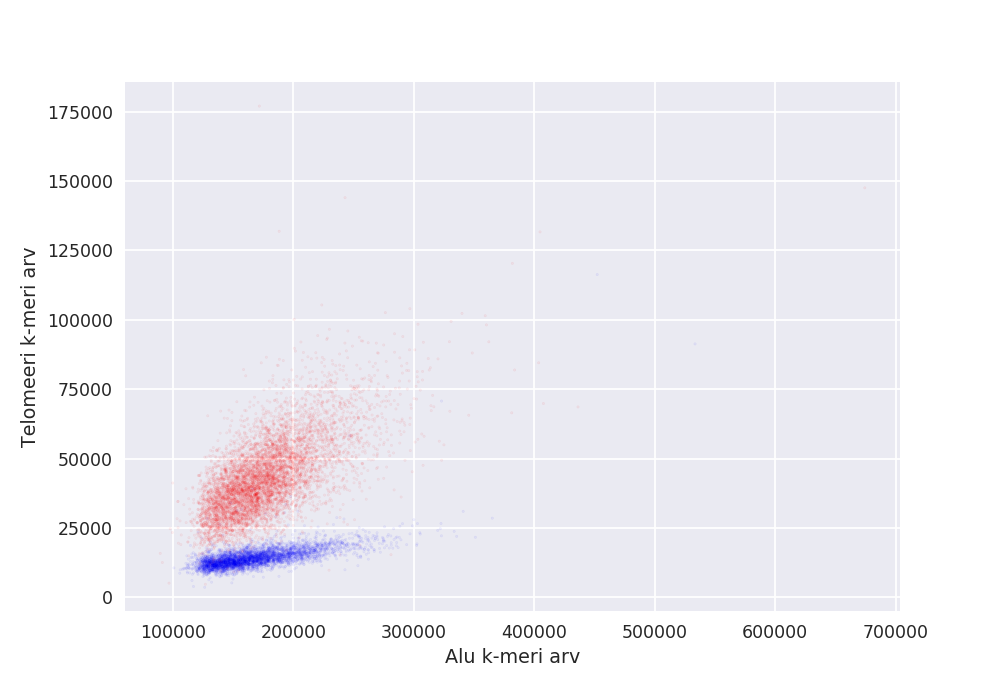

In [287]:
%matplotlib nbagg

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

tel_counts = map(lambda r: float(r.counts['TTAGGGTTAGGGTTAGGGTTAGGGT']), results)
#TTAGGGTTAGGGTTAGGGTTAGGGT

def count_alu(r):
    return r.counts['CTGTAATCCCAGCACTTTGGGAGGC']

alu_counts = map(count_alu, results)

plt.scatter(alu_counts,tel_counts ,s=2, alpha=0.05, c=map(lambda r: 'red' if int(r.read_length) is 166 else 'blue', results))

plt.ylabel('Telomeeri k-meri arv')

plt.xlabel('Alu k-meri arv')

plt.show()


<IPython.core.display.Javascript object>


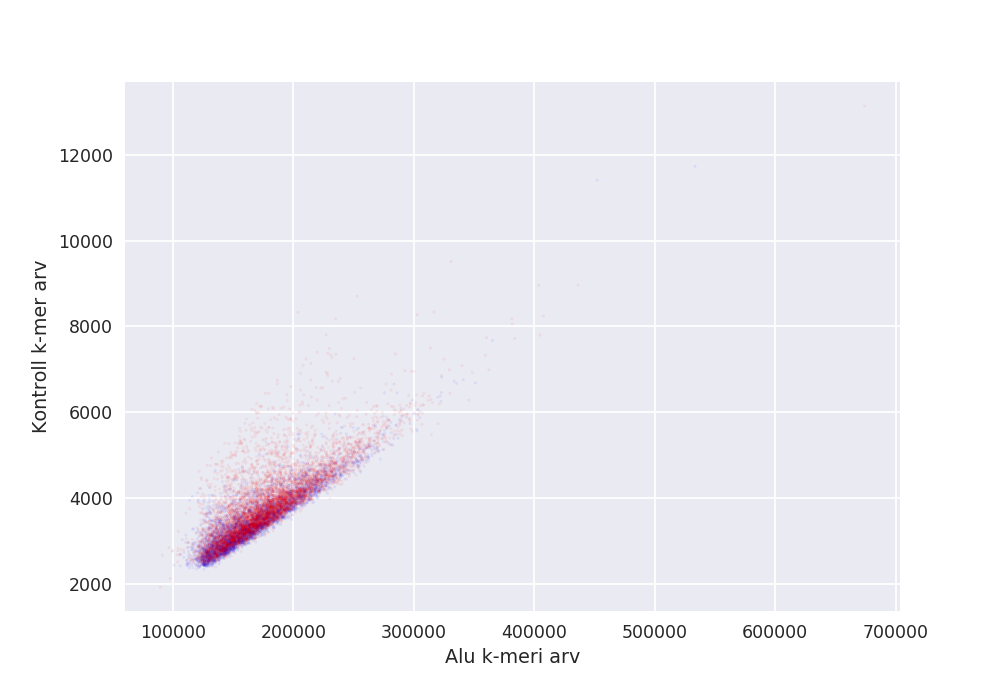

In [297]:
%matplotlib nbagg

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

other_alu = map(lambda r: float(r.mbases), results)
#TTAGGGTTAGGGTTAGGGTTAGGGT

def count_alu(r):
    return r.counts['CTGTAATCCCAGCACTTTGGGAGGC']

alu_counts = map(count_alu, results)
            
plt.scatter(alu_counts,other_alu ,s=2, alpha=0.05, c=map(lambda r: 'red' if int(r.read_length) is 166 else 'blue', results))

plt.xlabel('Alu k-meri arv')
plt.ylabel('Kontroll k-mer arv')

plt.show()


<IPython.core.display.Javascript object>


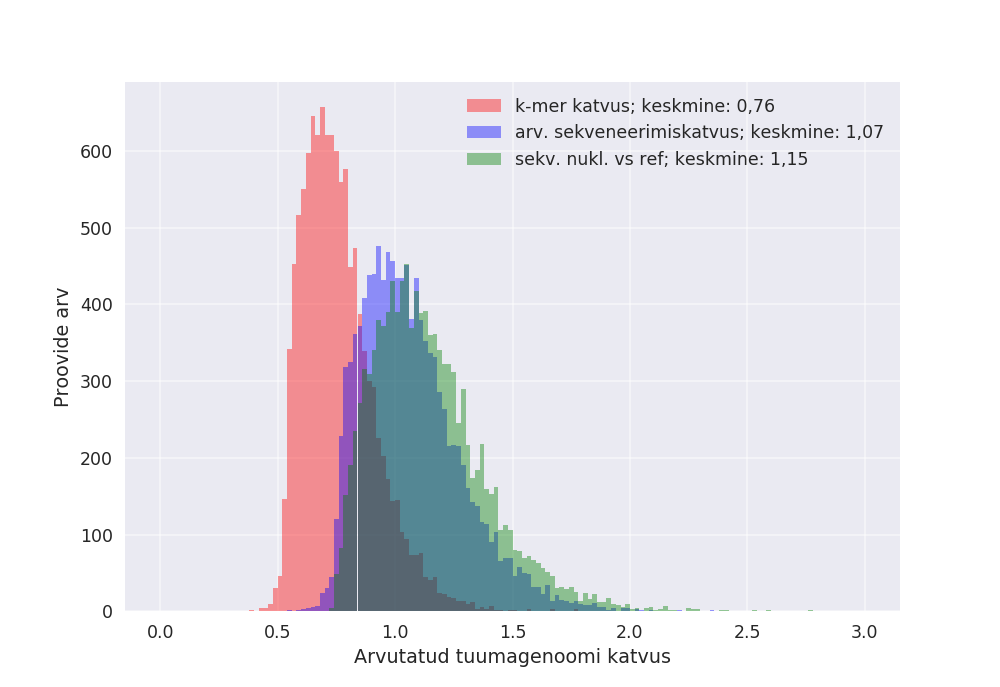

CTGTAATCCCAGCACTTTGGGAGGC esineb keskmiselt 
1.06920185102
korda
CTGTAATCCCAGCACTTTGGGAGGC põhjal arvutatud katvus on seega
0.760035050726


In [306]:
%matplotlib nbagg

import math
sns = None
#glistquery /storage7/g_vastus/HGDP00778_25_intrsec.list -q CTGTAATCCCAGCACTTTGGGAGGC
#CTGTAATCCCAGCACTTTGGGAGGC       5273596

buckets = 150
alu_result = 5273596.0
c = 23.0
alu_1x = alu_result/c
#alu_1x = 255563.0

read_length = 83.0
kmer_size=25.0

def mb_coverage(r):
    return float(r.mbases)/3227.

def k_coverage(r):
    kmer_coverage = float(r.counts['CTGTAATCCCAGCACTTTGGGAGGC'])/alu_1x
    return kmer_coverage

def coverage(r):
    kmer_coverage = float(r.counts['CTGTAATCCCAGCACTTTGGGAGGC'])/alu_1x
    return kmer_coverage/((read_length - kmer_size + 1) / read_length)

d = 0

y1 = list(map(k_coverage, results))
plt.hist(y1, buckets, alpha=.4, range=(0,3), facecolor="red", label="k-mer katvus; keskmine: "+str(round(np.average(y1),2)).replace('.',','))

y2 = list(map(coverage, results))
plt.hist(y2, buckets, alpha=.4, range=(0,3), facecolor="blue", label="arv. sekveneerimiskatvus; keskmine: "+str(round(np.average(y2),2)).replace('.',','))

y3 = list(map(mb_coverage, results))
plt.hist(y3, buckets, alpha=.4, range=(0,3), facecolor="green", label="sekv. nukl. vs ref; keskmine: "+str(round(np.average(y3),2)).replace('.',','))

print "CTGTAATCCCAGCACTTTGGGAGGC esineb keskmiselt "
print np.average(map(coverage, results))
print "korda"

print "CTGTAATCCCAGCACTTTGGGAGGC põhjal arvutatud katvus on seega"
print np.average(map(lambda r: float(r.counts['CTGTAATCCCAGCACTTTGGGAGGC']), results))/alu_1x


#plt.hist(c, 500, normed=1, alpha=0.5, facecolor="red")

#plt.axis([1.2-1, 2.8-1, 0, 400])
plt.legend()
plt.xlabel('Arvutatud tuumagenoomi katvus')
plt.ylabel('Proovide arv')
plt.grid(alpha=0.5)
plt.show()

Genoome pärast filtreerimist: 4597
Keskmine keskmine pikkus: 3785.17978671


<IPython.core.display.Javascript object>


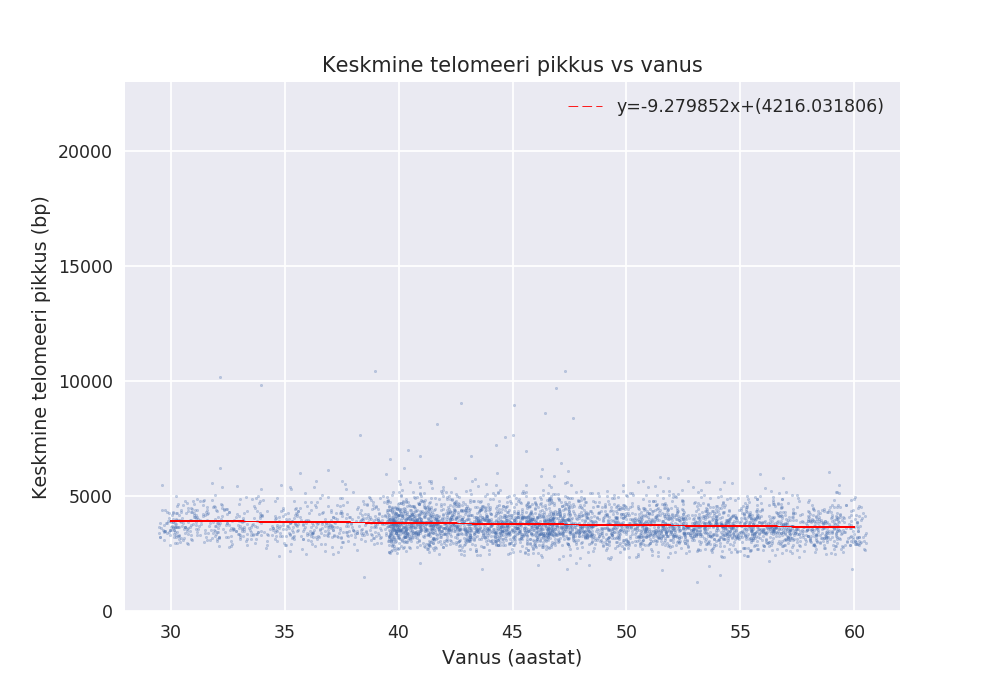

y=-9.279852x+(4216.031806)
3785.17978671
119632.306939


In [324]:
%matplotlib nbagg

import random

def calculate_avg_len(r):
    count = r.tel_count()
    cov = coverage(r)
    return ((count/cov)*25)/92

def get_x(r):
    return r.age+(random.random()-0.5) # shift the dot for cosmetic purposes

# filter the results
f_results = [r for r in results if int(r.read_length) is 165]
#f_results = results

print "Genoome pärast filtreerimist: "+ str(len(f_results))


x = list(map(get_x, f_results))
y = list(map(calculate_avg_len, f_results))

print "Keskmine keskmine pikkus: " + str(np.average(y))


labels = list(map(lambda r: r.get_label(), f_results))
plt.scatter(x, y, s=2, alpha=0.3)

true_x = map(lambda r: int(r.age), f_results)

z = np.polyfit(true_x, y, 1)
p = np.poly1d(z)
plt.plot(true_x,p(true_x),"r--", linewidth=0.5)
plt.legend( ["y=%.6fx+(%.6f)"%(z[0],z[1])])

plt.axis([28, 62, 0, 23000])
plt.xlabel('Vanus (aastat)')
plt.ylabel('Keskmine telomeeri pikkus (bp)')
plt.title("Keskmine telomeeri pikkus vs vanus")

plt.show()

print "y=%.6fx+(%.6f)"%(z[0],z[1])
print np.average(y)
print np.average([r.counts['TGTAATCCCAGCACTTTGGGAGGCC'] for r in f_results])

<IPython.core.display.Javascript object>


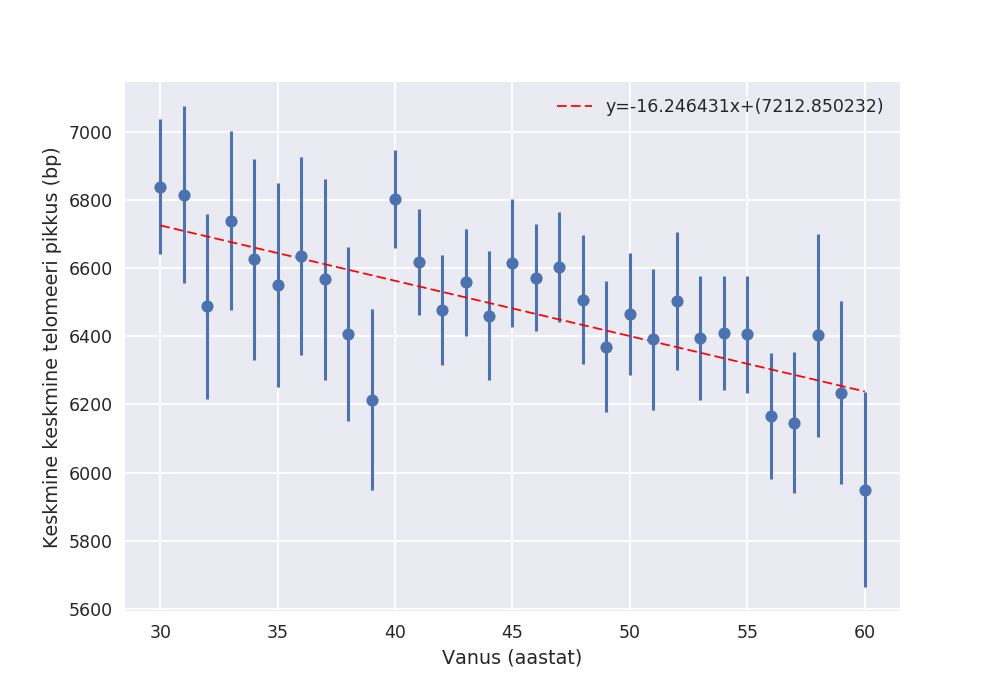

In [322]:
%matplotlib nbagg

import scipy.stats as st


counts_by_age = dict()

for r in f_results:
    if r.age not in counts_by_age:
        counts_by_age[r.age] = list()
    counts_by_age[r.age].append(calculate_avg_len(r))
    
xg = range(30,61)

yg = [np.average(counts_by_age[a]) for a in xg]

cg = [st.t.interval(0.95, len(counts_by_age[a])-1, loc=np.mean(counts_by_age[a]), scale=st.sem(counts_by_age[a])) for a in xg]
#plt.scatter(xg, yg, s=2, alpha=1)

yerrups = [e[1]-np.average(counts_by_age[a+30]) for a,e in enumerate(cg)]
yerrdowns =  [np.average(counts_by_age[a+30]-e[0]) for a,e in enumerate(cg)]

plt.errorbar(xg, yg, yerr=[yerrups, yerrdowns],fmt='o')

z = np.polyfit(xg, yg, 1)
p = np.poly1d(z)
plt.plot(xg,p(xg),"r--", linewidth=1)
plt.legend( ["y=%.6fx+(%.6f)"%(z[0],z[1])])
plt.xlabel('Vanus (aastat)')
plt.ylabel('Keskmine keskmine telomeeri pikkus (bp)')

plt.show()

<IPython.core.display.Javascript object>


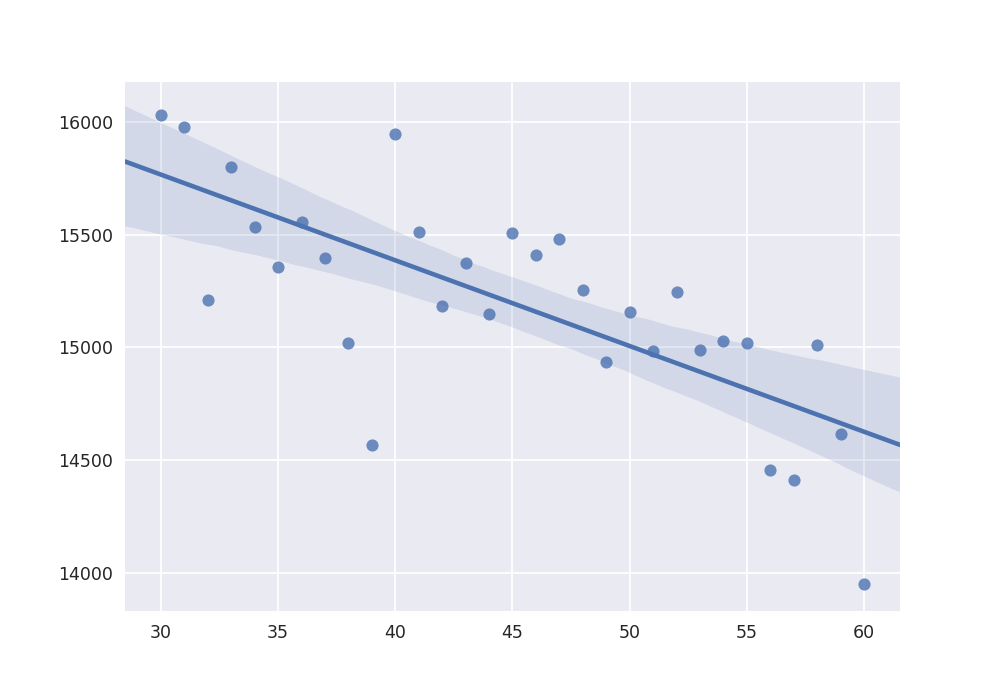

In [232]:
%matplotlib nbagg
import seaborn as sns

xgi = np.array([int(t) for t in xg])
ygi = np.array([int(t) for t in yg])

sns.regplot(xgi,ygi, ci=95)

<IPython.core.display.Javascript object>


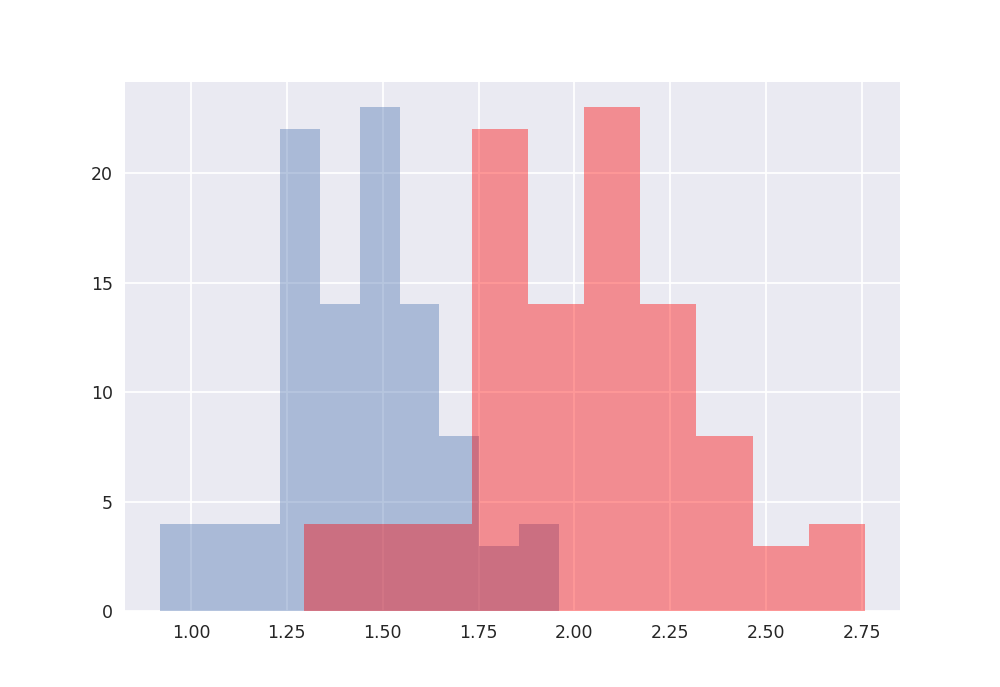

1.4404
2.02632542373


In [239]:
%matplotlib nbagg
bases = np.array(['A', 'T', 'C', 'G'])


genome_length = 10000000
read_length = 83
seq_coverage = 1.7
kmer_length = 15
genome_alu_count = 25
alu = 'ATGACTAGAGCTCTTAGAGTAGCATAGAGTACGATAGA'[0:kmer_length]


def get_genome():
    genome = np.random.choice(bases, genome_length)
    for i in range(0, genome_alu_count):
        d = np.random.randint(0, genome_length-len(alu))
        for n,j in enumerate(alu):
            genome[d+n] = j
    return genome


def get_read(genome):
    d = np.random.randint(0, genome_length-read_length)
    return genome[d:d+read_length]

def get_kmers(read):    
    kmers = []
    n = len(read)
    for i in range(0, n-kmer_length+1):
        kmers.append(read[i:i+kmer_length].tostring())
    return (kmers)


alu_counts = []
act_covs = []

for i in range(0,100):
    genome = get_genome()
    reads = np.array([get_read(genome) for i in range(0, int(genome_length/read_length*seq_coverage))])
    
    kmer_counts = dict()
    
    for read in reads:
        kmers = get_kmers(read)
        for km in kmers:
            if km not in kmer_counts:
                kmer_counts[km] = 0
            kmer_counts[km]+=1
    if alu in kmer_counts:
        alu_counts.append(float(kmer_counts[alu])/float(genome_alu_count))
        act_covs.append((float(kmer_counts[alu])/float(genome_alu_count))/((read_length - kmer_size + 1) / read_length))

            
plt.hist(alu_counts, alpha=0.4)
plt.hist(act_covs, alpha=0.4, facecolor="red")
print np.mean(alu_counts)
print np.mean(act_covs)
            
#plt.scatter(xc,yc)
#z = np.polyfit(xc, yc, 1)
#p = np.poly1d(z)
#plt.plot(xc,p(xc),"r--", linewidth=1)
#plt.legend( ["y=%.6fx+(%.6f)"%(z[0],z[1])])
plt.show()

#sns.regplot(xgi,ygi, ci=95)


In [153]:
import scipy.special as sp



print sp.binom(3.2e9, 255563)

inf


In [243]:
kmer_coverage = (22)/((read_length - kmer_size + 1) / read_length)

print (100. - 25. + 1.) / 100.


print kmer_coverage




0.76
30.9491525424


In [319]:
lng_tel = 'TTAGGGTTAGGGTTAGGGTTAGGG'*100
read_tel = lng_tel[0:83]
kmer_length = 25
print read_tel
print get_kmers(np.array(list(read_tel)))



TTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGG
['TTAGGGTTAGGGTTAGGGTTAGGGT', 'TAGGGTTAGGGTTAGGGTTAGGGTT', 'AGGGTTAGGGTTAGGGTTAGGGTTA', 'GGGTTAGGGTTAGGGTTAGGGTTAG', 'GGTTAGGGTTAGGGTTAGGGTTAGG', 'GTTAGGGTTAGGGTTAGGGTTAGGG', 'TTAGGGTTAGGGTTAGGGTTAGGGT', 'TAGGGTTAGGGTTAGGGTTAGGGTT', 'AGGGTTAGGGTTAGGGTTAGGGTTA', 'GGGTTAGGGTTAGGGTTAGGGTTAG', 'GGTTAGGGTTAGGGTTAGGGTTAGG', 'GTTAGGGTTAGGGTTAGGGTTAGGG', 'TTAGGGTTAGGGTTAGGGTTAGGGT', 'TAGGGTTAGGGTTAGGGTTAGGGTT', 'AGGGTTAGGGTTAGGGTTAGGGTTA', 'GGGTTAGGGTTAGGGTTAGGGTTAG', 'GGTTAGGGTTAGGGTTAGGGTTAGG', 'GTTAGGGTTAGGGTTAGGGTTAGGG', 'TTAGGGTTAGGGTTAGGGTTAGGGT', 'TAGGGTTAGGGTTAGGGTTAGGGTT', 'AGGGTTAGGGTTAGGGTTAGGGTTA', 'GGGTTAGGGTTAGGGTTAGGGTTAG', 'GGTTAGGGTTAGGGTTAGGGTTAGG', 'GTTAGGGTTAGGGTTAGGGTTAGGG', 'TTAGGGTTAGGGTTAGGGTTAGGGT', 'TAGGGTTAGGGTTAGGGTTAGGGTT', 'AGGGTTAGGGTTAGGGTTAGGGTTA', 'GGGTTAGGGTTAGGGTTAGGGTTAG', 'GGTTAGGGTTAGGGTTAGGGTTAGG', 'GTTAGGGTTAGGGTTAGGGTTAGGG', 'TTAGGGTTAGGGTTAGGGTTAGGGT', 'TAGGGTTAGGGTTAG